In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [3]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [4]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [5]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [6]:
INPUT_DIM = 8
OUTPUT_DIM = 8

In [7]:
dims = [INPUT_DIM, 100, 100, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [8]:
target_dims = [INPUT_DIM, 10, OUTPUT_DIM]
Target_TBNN = bnn.network.TernBinNetwork(
    *target_dims,
    forward_func=forward_func,
    backward_func=None,
)
Target_TBNN._initialise(W_mean=0, W_zero_prob=0.8)

In [9]:
DL = bnn.data.target_network_factory(
    datapoints=1000,
    batch_size=1000,
    target_network=Target_TBNN,
    include_last_if_uneven=True,
)

In [10]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [11]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [12]:
losses = []

In [13]:
train_epochs = 500
num_logs = 10
epoch_log_rate = train_epochs // num_logs

In [14]:
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    for batch in DL:
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        BernOpt.step(number_of_samples=len(batch.input))

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss)

    early_exit = epoch_loss == 0
    if early_exit or (epoch % epoch_log_rate) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

  1%|          | 3/500 [00:00<00:42, 11.59it/s]

epoch: 0	loss: 7466


 10%|█         | 52/500 [00:05<00:50,  8.88it/s]

epoch: 50	loss: 1060


 21%|██        | 103/500 [00:11<00:32, 12.18it/s]

epoch: 100	loss: 1208


 30%|███       | 152/500 [00:17<00:50,  6.95it/s]

epoch: 150	loss: 1234


 40%|████      | 202/500 [00:21<00:28, 10.62it/s]

epoch: 200	loss: 1026


 50%|█████     | 252/500 [00:26<00:29,  8.51it/s]

epoch: 250	loss: 968


 60%|██████    | 302/500 [00:33<00:23,  8.41it/s]

epoch: 300	loss: 1204


 70%|███████   | 352/500 [00:37<00:11, 13.07it/s]

epoch: 350	loss: 1104


 80%|████████  | 402/500 [00:43<00:12,  7.99it/s]

epoch: 400	loss: 1308


 90%|█████████ | 452/500 [00:48<00:07,  6.38it/s]

epoch: 450	loss: 1154


100%|██████████| 500/500 [00:53<00:00,  9.27it/s]


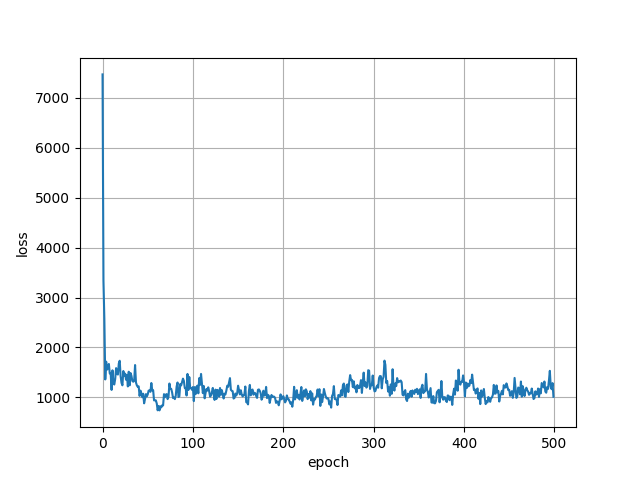

In [15]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [16]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 1,  0,  1,  0,  0,  1,  1, -1, -1,  0,  0, -1,  1,  1, -1,  1,  0,  0,
          0, -1,  0,  1,  1,  1, -1, -1,  1, -1,  1, -1,  0,  1, -1,  0, -1,  0,
         -1,  1, -1,  1,  1,  0, -1,  1, -1,  1,  1,  0,  1,  0, -1,  1, -1,  1,
          0, -1, -1,  0, -1,  1,  0,  1,  1, -1, -1,  0,  0, -1, -1,  0, -1,  1,
         -1,  1,  0,  1,  1,  0,  1,  0,  1,  0, -1, -1,  1,  1,  0, -1,  0, -1,
         -1,  0,  0,  1, -1, -1,  0,  0,  1, -1],
        [ 1,  1,  0,  1, -1, -1, -1,  1,  1,  1,  1,  0,  1,  0, -1, -1,  1, -1,
          1,  0, -1,  0, -1,  0, -1,  1,  1,  0,  0,  0,  0,  1,  0, -1,  1, -1,
         -1, -1, -1,  1,  0,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  0, -1, -1,
          1, -1,  1,  0, -1,  1,  0, -1, -1,  0,  1, -1,  1,  1, -1,  1, -1, -1,
          0,  1,  0,  1, -1,  0,  0,  0, -1, -1,  1,  0, -1, -1, -1,  1,  1, -1,
         -1,  1, -1, -1,  0,  1, -1,  0,  1, -1],
        [ 0,  0,  0, -1, -1,  1,  1,  0,  0

In [17]:
assert bnn.network.network_params_al_ternary(TBNN)